In [1]:
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from tegame import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Initialize a list to store all simulation outcomes
raw_results = []

# Define the ranges of threshold values to explore
threshold1_range = range(1, 30)   # values for thresh_nonmandatory
threshold2_range = range(1, 30)   # values for thresh_secondchoice

# Number of simulations to run for each parameter combination
N_sim = 200

#generate N_sim decks and hands
games=[]
for sim in range(N_sim):
    game = Tegame(players=2)
    game.restart()
    games.append(game)
    
# Loop over all combinations of threshold parameters
for thresh_sec in tqdm(threshold2_range, desc="thresh_secondchoice"):
    for thresh_non in threshold1_range:
        # Run N_sim independent games for each parameter pair
        for sim in range(N_sim):
            game = Tegame(
                players=2,
                verb_lvl=0,
                thresh_secondchoice=thresh_sec,
                thresh_nonmandatory=thresh_non
            )
            
            # Reset the game state before each simulation
            game.restart()

            #set the pre-generated initial state
            state = games[sim].get_state().copy()
            game.set_state(state)
            
            # Run the game and record whether it was won (1) or lost (0)
            game_won = game.run_game()

            # Store the result along with the parameter values
            raw_results.append({
                "thresh_secondchoice": thresh_sec,
                "thresh_nonmandatory": thresh_non,
                "win": int(game_won)
            })

# Convert all collected results into a DataFrame for analysis
df_raw = pd.DataFrame(raw_results)

thresh_secondchoice: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:29<00:00,  1.02s/it]


Top 3 pairs: [(15, 15), (20, 28), (20, 4)]


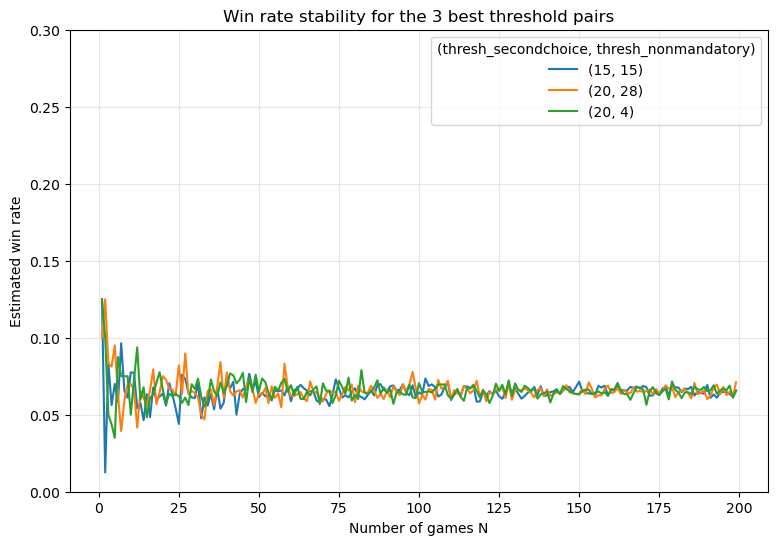

In [3]:
# 1. Identify the top 3 threshold pairs
# Compute the mean win rate for each combination of thresholds
df_summary = (
    df_raw
    .groupby(["thresh_secondchoice", "thresh_nonmandatory"])["win"]
    .mean()
    .reset_index()
)

# Select the three combinations with the highest average win rate
top3 = df_summary.sort_values("win", ascending=False).head(3)
top3_pairs = list(zip(top3["thresh_secondchoice"], top3["thresh_nonmandatory"]))

print("Top 3 pairs:", top3_pairs)

# 2. Bootstrap parameters
# We estimate how the win rate behaves when using fewer games (N)
sample_sizes = np.arange(1,N_sim)
bootstrap_runs = 40   # number of bootstrap resamples for each N

plt.figure(figsize=(9,6))

# 3. Loop over the three best threshold pairs
for pair in top3_pairs:
    # Extract the 30 win/loss outcomes for this specific threshold pair
    df_pair = df_raw[
        (df_raw["thresh_secondchoice"] == pair[0]) &
        (df_raw["thresh_nonmandatory"] == pair[1])
    ]["win"].values

    # Dictionary to store bootstrap means for each sample size
    means_dict = {n: [] for n in sample_sizes}

    # Bootstrap resampling
    for n in sample_sizes:
        for _ in range(bootstrap_runs):
            # Sample n games with replacement and compute the mean win rate
            sample = np.random.choice(df_pair, size=n, replace=True)
            means_dict[n].append(sample.mean())

    # Compute mean estimate and confidence intervals for each N
    mean_est = [np.mean(means_dict[n]) for n in sample_sizes]
    ci_low = [np.percentile(means_dict[n], 2.5) for n in sample_sizes]
    ci_high = [np.percentile(means_dict[n], 97.5) for n in sample_sizes]

    # Plot the estimated win rate curve
    label = f"({pair[0]}, {pair[1]})"
    plt.plot(sample_sizes, mean_est, label=label)

# 4. Finalize the plot
plt.xlabel("Number of games N");
plt.ylabel("Estimated win rate");
plt.title("Win rate stability for the 3 best threshold pairs");
plt.grid(True, alpha=0.3);
plt.legend(title="(thresh_secondchoice, thresh_nonmandatory)");
plt.ylim(0,0.3);
plt.show()

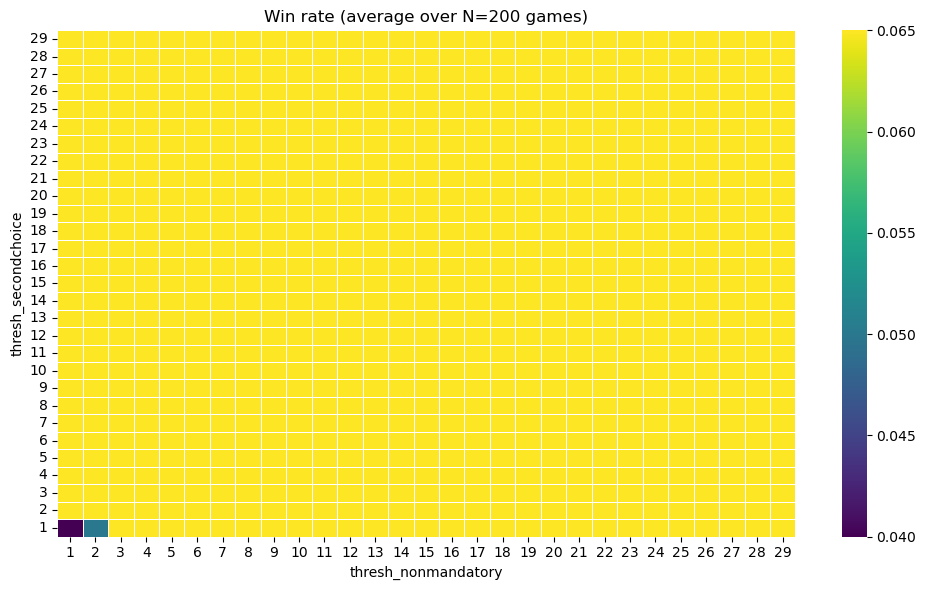

In [4]:
# Compute the average win rate for each pair of threshold parameters
df_summary = (
    df_raw
    .groupby(["thresh_secondchoice", "thresh_nonmandatory"])["win"]
    .mean()
    .reset_index()
)

# Pivot the table to create a 2D matrix suitable for a heatmap
heatmap_data = df_summary.pivot(
    index="thresh_secondchoice",
    columns="thresh_nonmandatory",
    values="win"
)

plt.figure(figsize=(10, 6))

# Draw the heatmap of win rates across the parameter grid
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    linewidths=0.5,
    fmt=".2f"
)

plt.title(f"Win rate (average over N={N_sim} games)")
plt.xlabel("thresh_nonmandatory")
plt.ylabel("thresh_secondchoice")

# Invert the Y‑axis so that lower threshold values appear at the bottom
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
